## 1. Import des librairies

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from string import punctuation
from bs4 import BeautifulSoup
from wordcloud import WordCloud

sns.set_style("whitegrid")
%matplotlib inline

## 2. Chargement des données

In [2]:
df = pd.read_csv("data/QueryResults.csv")

SELECT title, body, tags FROM posts 
WHERE title is not null and 
      body is not null and 
      tags is not null and 
      FavoriteCount>50 and
      AnswerCount>5 and
      Score>5

In [3]:
df

,title,body,tags
0,Recommended Fonts for Programming?,"<p>What fonts do you use for programming, and ...",<fonts><development-environment>
1,Why should I learn Lisp?,"<p>I really feel that I should learn <a href=""...",<functional-programming><lisp>
2,Restart node upon changing a file,<p>For someone who is coming from PHP backgrou...,<node.js>
3,100% Min Height CSS layout,<blockquote>\n <p>What's the best way to make...,<html><css><xhtml>
4,How does Stack Overflow generate its SEO-frien...,"<p>What is a good complete <a href=""http://en....",<regex><language-agnostic><seo><friendly-url><...
...,...,...,...
16369,Can Selenium Webdriver open browser windows si...,<p>I have a selenium test suite that runs many...,<selenium><selenium-webdriver><webdriver><sele...
16370,How to symbolicate crash log Xcode?,<p>Xcode 5 organizer had a view which would li...,<ios><xcode>
16371,Spring Boot and multiple external configuratio...,<p>I have multiple property files that I want ...,<java><spring><config><spring-boot>
16372,Java's final vs. C++'s const,"<p>The <a href=""http://triton.towson.edu/~mzim...",<java><c++><const><final>


## 3. Prétraitement des données

### 3.1. Gestion des doublons

In [4]:
print(df.duplicated().sum())
df = df.drop_duplicates()

0


### 3.2. Modification des tags

In [5]:
def rewrite_tags(text):
    text = re.sub("<", "", text)
    text = re.sub(">", " ", text)
    return text

In [6]:
df["tags"] = df["tags"].apply(lambda x: rewrite_tags(x))

## 4. Analyse exploratoire basique sur les tags

### 4.1. Fréquence de tag_count

In [7]:
df["tag_count"] = df["tags"].apply(lambda x: len(x.split()))

In [8]:
df["tag_count"].value_counts()

3    4863
2    3912
4    3779
5    2658
1    1162
Name: tag_count, dtype: int64

In [9]:
print( "Nombre de tag maximum pour une question: ", df["tag_count"].max())
print( "Nombre de tag minimum pour une question: ", df["tag_count"].min())
print( "Nombre de tag moyen pour une question: ", df["tag_count"].mean())

Nombre de tag maximum pour une question:  5
Nombre de tag minimum pour une question:  1
Nombre de tag moyen pour une question:  3.1746060828142175


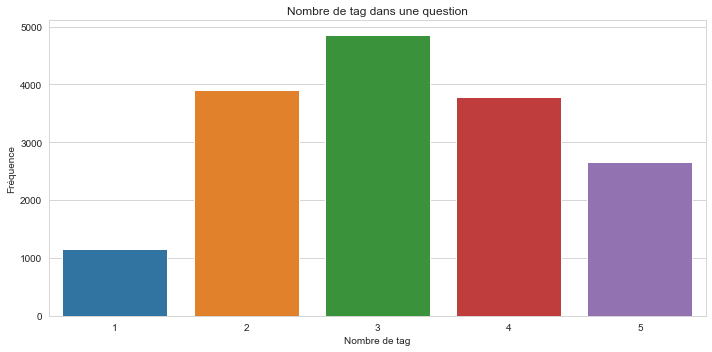

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(df["tag_count"])
plt.title("Nombre de tag dans une question")
plt.xlabel("Nombre de tag")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

Observations:
    1. Nombre maximum de tag pour une question : 5
    2. Nombre minimum de tag pour une question : 1
    3. Nombre moyen de tag pour une question: 3.17
    4. La plupart des question ont entre 2 et 4 tags

### 4.2. Nombre total de tags unique

In [11]:
countVectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = countVectorizer.fit_transform(df['tags'])

In [12]:
print("Nombre de questions : ", tag_bow.shape[0])
print("Nombre de tag unique : ", tag_bow.shape[1])

Nombre de questions :  16374
Nombre de tag unique :  6159


In [13]:
tags = countVectorizer.get_feature_names()
print("Quelques tags : ", tags[:10])

Quelques tags :  ['.a', '.bash-profile', '.d.ts', '.htaccess', '.net', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.5']


### 4.3. Fréquence de chaque tags

In [14]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

In [15]:
list = []
for key, value in tag_to_count_map.items():
    list.append([key, value])

In [16]:
tag_df = pd.DataFrame(list, columns=['tags', 'counts'])
tag_df.head()

,tags,counts
0,.a,1
1,.bash-profile,1
2,.d.ts,1
3,.htaccess,22
4,.net,459


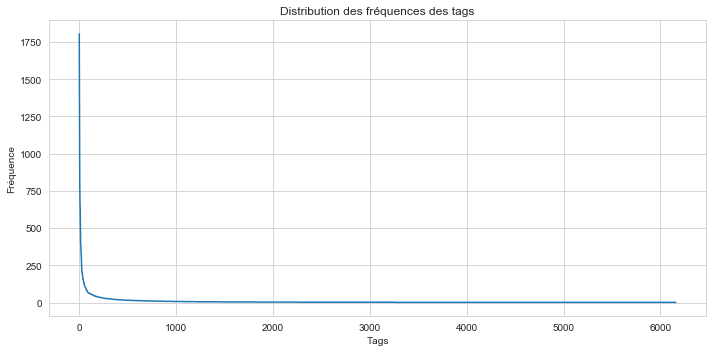

In [17]:
tag_df_sorted = tag_df.sort_values(['counts'], ascending=False)
plt.figure(figsize=(10, 5))
plt.plot(tag_df_sorted['counts'].values)
plt.title("Distribution des fréquences des tags")
plt.xlabel("Tags")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

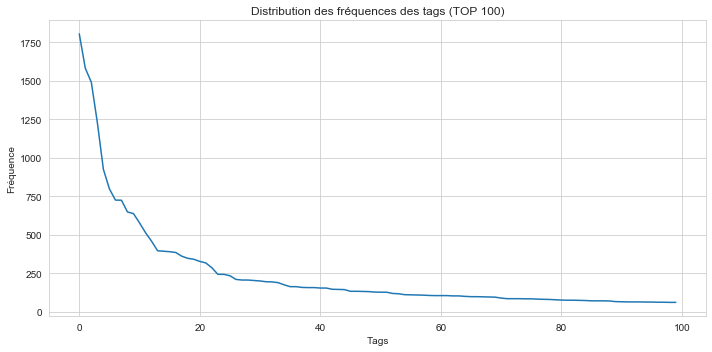

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(tag_df_sorted['counts'][0:100].values)
plt.title("Distribution des fréquences des tags (TOP 100)")
plt.xlabel("Tags")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

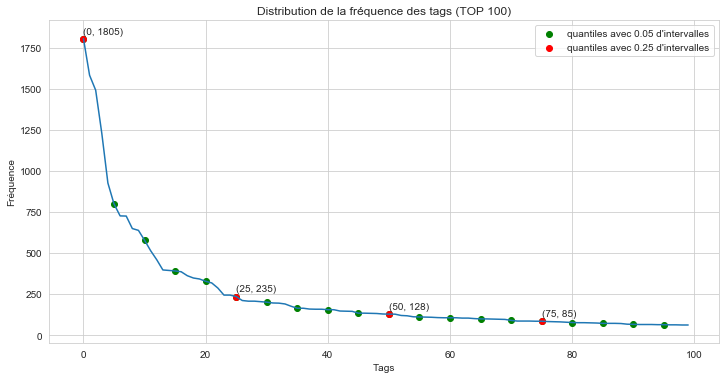

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(tag_df_sorted['counts'][0:100].values)
plt.scatter(x=np.arange(0, 100, 5), y=tag_df_sorted['counts'][0:100:5], c='g', label="quantiles avec 0.05 d'intervalles")
plt.scatter(x=np.arange(0, 100, 25), y=tag_df_sorted['counts'][0:100:25], c='r', label="quantiles avec 0.25 d'intervalles")
for x, y in zip(np.arange(0, 100, 25), tag_df_sorted['counts'][0:100:25]):
    plt.annotate(s="({}, {})".format(x, y), xy=(x,y), xytext=(x-0.01, y+30))
plt.tight_layout()
plt.title("Distribution de la fréquence des tags (TOP 100)")
plt.xlabel("Tags")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

In [20]:
print("{} tags sont utilisés plus de 100 fois.".format(tag_df_sorted[tag_df_sorted["counts"] > 100].shape[0]))
print("{} tags sont utilisés plus de 500 fois.".format(tag_df_sorted[tag_df_sorted["counts"] > 500].shape[0]))

65 tags sont utilisés plus de 100 fois.
12 tags sont utilisés plus de 500 fois.


Observations:
    1. 65 tags sont utilisés plus de 100 fois.
    2. 12 tags sont utilisés plus de 500 fois.
    3. javascript est le tag plus utilisés avec 1805 fois.

### 4.4. Carte des mots pour les tags les plus fréquents

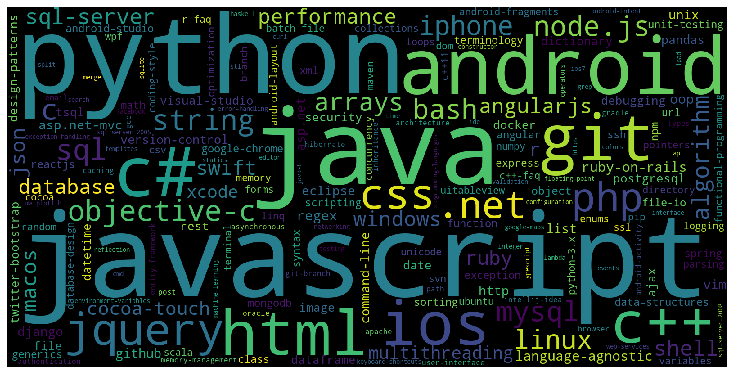

In [21]:
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600, height=800,).generate_from_frequencies(tupl)
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Observations:
    1. "javascript", "java", "python", "android", "jquery", "html", "git" et "C#" sont les tags les plus fréquents.

In [22]:
tag_df_sorted.head(20)["tags"]

2942     javascript
4350         python
2914           java
142         android
828              c#
2230            git
2546           html
2834            ios
833             c++
2989         jquery
1277            css
4087            php
4              .net
3837    objective-c
5056            sql
5204         string
827               c
3596          mysql
3709        node.js
657            bash
Name: tags, dtype: object

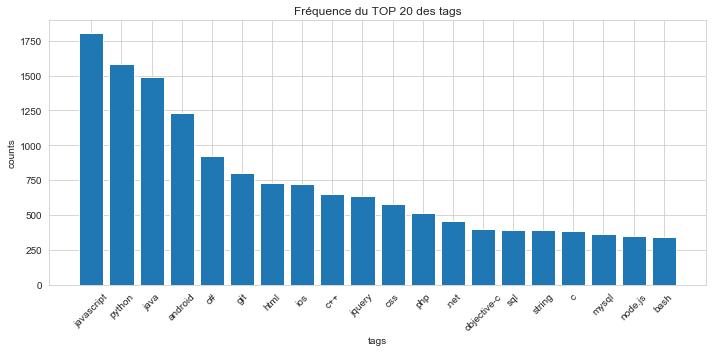

In [23]:
i=np.arange(20)
plt.figure(figsize=(10, 5))
plt.bar(tag_df_sorted.head(20)["tags"], tag_df_sorted.head(20)["counts"])
plt.title("Fréquence du TOP 20 des tags")
plt.xlabel("tags")
plt.ylabel("counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
df.drop(columns=["tag_count"], inplace=True)

On garde seulement les 100 tags les plus utilisés

In [25]:
df["tags"] = df["tags"].apply(lambda x: x.split())

In [26]:
flat_list = [item for sublist in df["tags"].values for item in sublist]

keywords = nltk.FreqDist(flat_list)
keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [27]:
tags_features

['javascript',
 'python',
 'java',
 'android',
 'c#',
 'git',
 'html',
 'ios',
 'c++',
 'jquery',
 'css',
 'php',
 '.net',
 'objective-c',
 'sql',
 'string',
 'c',
 'mysql',
 'node.js',
 'bash',
 'iphone',
 'linux',
 'arrays',
 'algorithm',
 'sql-server',
 'shell',
 'performance',
 'windows',
 'angularjs',
 'macos',
 'json',
 'swift',
 'database',
 'ruby',
 'r',
 'multithreading',
 'cocoa-touch',
 'xcode',
 'language-agnostic',
 'oop',
 'regex',
 'ruby-on-rails',
 'list',
 'github',
 'vim',
 'django',
 'asp.net-mvc',
 'asp.net',
 'command-line',
 'http',
 'unix',
 'eclipse',
 'version-control',
 'pandas',
 'visual-studio',
 'ajax',
 'docker',
 'file',
 'dictionary',
 'postgresql',
 'rest',
 'image',
 'design-patterns',
 'dataframe',
 'datetime',
 'twitter-bootstrap',
 'tsql',
 'date',
 'security',
 'debugging',
 'object',
 'syntax',
 'sorting',
 'google-chrome',
 'exception',
 'function',
 'npm',
 'spring',
 'unit-testing',
 'terminology',
 'reactjs',
 'math',
 'mongodb',
 'xml',
 'cla

In [28]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [29]:
df["tags"] = df["tags"].apply(lambda x: most_common(x))
df["tags"] = df["tags"].apply(lambda x: x if len(x) > 0 else None)

In [30]:
df.dropna(subset=["tags"], inplace=True)

In [31]:
df

,title,body,tags
2,Restart node upon changing a file,<p>For someone who is coming from PHP backgrou...,[node.js]
3,100% Min Height CSS layout,<blockquote>\n <p>What's the best way to make...,"[html, css]"
4,How does Stack Overflow generate its SEO-frien...,"<p>What is a good complete <a href=""http://en....","[regex, language-agnostic]"
5,Get OS-level system information,<p>I'm currently building a Java app that coul...,[java]
6,Disable browser 'Save Password' functionality,<p>One of the joys of working for a government...,[security]
...,...,...,...
16368,What is the difference between an interface an...,<p>What exactly is the difference between an i...,[oop]
16370,How to symbolicate crash log Xcode?,<p>Xcode 5 organizer had a view which would li...,"[ios, xcode]"
16371,Spring Boot and multiple external configuratio...,<p>I have multiple property files that I want ...,"[java, spring]"
16372,Java's final vs. C++'s const,"<p>The <a href=""http://triton.towson.edu/~mzim...","[java, c++]"


## 5. Prétraitement du texte

### 5.1. Suppression du code HTML

In [32]:
df["body"] = df["body"].apply(lambda x: BeautifulSoup(x).get_text())

In [33]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [34]:
df["document"] = df["title"] + " " + df["body"]
df.drop(columns=["title", "body"], inplace=True)

### 5.2. Suppression de la ponctuation

In [35]:
token = ToktokTokenizer()

In [36]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def clean_punct(text):
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punctuation))
    remove_punctuation = str.maketrans(' ', ' ', punctuation)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
    filtered_list = strip_list_noempty(punctuation_filtered)
    
    return ' '.join(map(str, filtered_list))

In [37]:
df["document"] = df["document"].apply(lambda x: clean_punct(x))

In [38]:
df["document"][2]

'Restart node upon changing a file For someone who is coming from PHP background the process of killing node and starting it again after every code change seems very tedious Is there any flag when starting a script with node to automatically restart node when code change is saved'

### 5.3. Suppression des stop words

In [39]:
def stopWordsRemove(text):
    stop_words = set(stopwords.words("english"))
    words = token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

In [40]:
df["document"] = df["document"].apply(lambda x: stopWordsRemove(x))

In [41]:
df["document"][2]

'Restart node upon changing file For someone coming PHP background process killing node starting every code change seems tedious Is flag starting script node automatically restart node code change saved'

### 5.4. Lemmatisation

In [42]:
lemma = WordNetLemmatizer()
def lemitizeWords(text):
    words = token.tokenize(text)
    listLemma = []
    for w in words:
        x = lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

In [43]:
df["document"] = df["document"].apply(lambda x: lemitizeWords(x))

In [44]:
df["document"][2]

'Restart node upon change file For someone come PHP background process kill node start every code change seem tedious Is flag start script node automatically restart node code change save'

## 6. Analyse exploratoire basique sur les documents

### 6.1. Fréquence de words_count

In [45]:
df["words_count"] = df["document"].apply(lambda x: len(x.split()))

In [46]:
df["words_count"].value_counts()

28      238
30      229
26      224
29      214
34      212
       ... 
814       1
966       1
1046      1
1566      1
1423      1
Name: words_count, Length: 487, dtype: int64

In [47]:
print( "Nombre de mots maximum pour une question: ", df["words_count"].max())
print( "Nombre de mots minimum pour une question: ", df["words_count"].min())
print( "Nombre de mots moyen pour une question: ", df["words_count"].mean())

Nombre de mots maximum pour une question:  2078
Nombre de mots minimum pour une question:  4
Nombre de mots moyen pour une question:  71.34767814251401


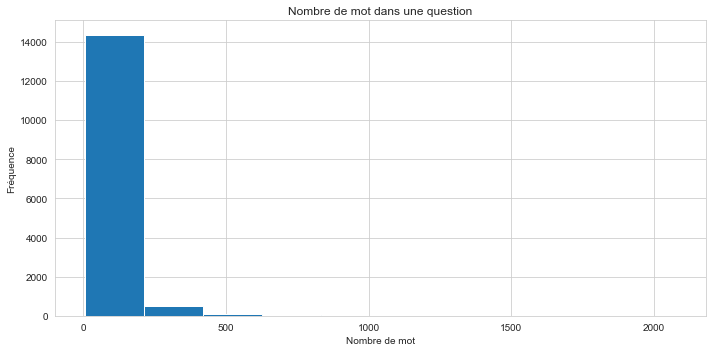

In [48]:
plt.figure(figsize=(10, 5))
plt.hist(df["words_count"], bins=10)
plt.title("Nombre de mot dans une question")
plt.xlabel("Nombre de mot")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

### 6.2. Nombre total de mot unique

In [49]:
countVectorizer = CountVectorizer(tokenizer = lambda x: x.split())
word_bow = countVectorizer.fit_transform(df['document'])

In [50]:
print("Nombre de questions : ", word_bow.shape[0])
print("Nombre de mot unique : ", word_bow.shape[1])

Nombre de questions :  14988
Nombre de mot unique :  71852


In [51]:
words = countVectorizer.get_feature_names()

### 6.3. Fréquence de chaque mots

In [52]:
freq = word_bow.sum(axis=0).A1
word_to_count_map = dict(zip(words, freq))

In [53]:
list = []
for key, value in word_to_count_map.items():
    list.append([key, value])

In [54]:
word_df = pd.DataFrame(list, columns=['word', 'counts'])
word_df.head()

,word,counts
0,.net,25
1,0,3056
2,00,487
3,000,98
4,0000,31


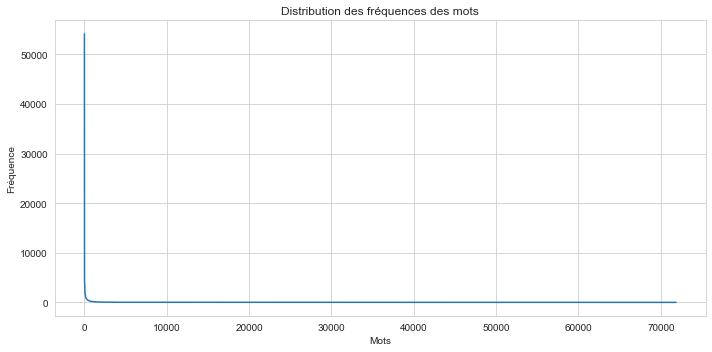

In [55]:
word_df_sorted = word_df.sort_values(['counts'], ascending=False)
plt.figure(figsize=(10, 5))
plt.plot(word_df_sorted['counts'].values)
plt.title("Distribution des fréquences des mots")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

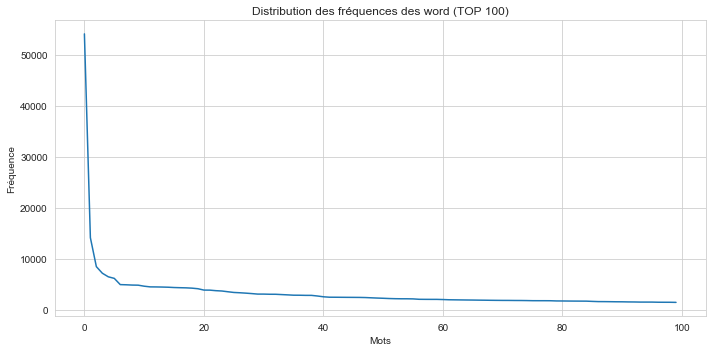

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(word_df_sorted['counts'][0:100].values)
plt.title("Distribution des fréquences des word (TOP 100)")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

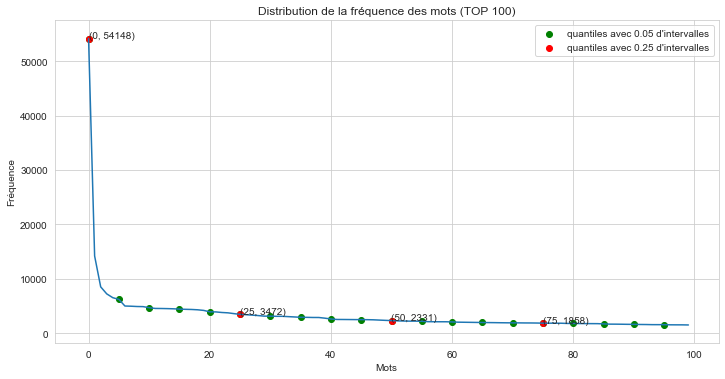

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(word_df_sorted['counts'][0:100].values)
plt.scatter(x=np.arange(0, 100, 5), y=word_df_sorted['counts'][0:100:5], c='g', label="quantiles avec 0.05 d'intervalles")
plt.scatter(x=np.arange(0, 100, 25), y=word_df_sorted['counts'][0:100:25], c='r', label="quantiles avec 0.25 d'intervalles")
for x, y in zip(np.arange(0, 100, 25), word_df_sorted['counts'][0:100:25]):
    plt.annotate(s="({}, {})".format(x, y), xy=(x,y), xytext=(x-0.01, y+30))
plt.tight_layout()
plt.title("Distribution de la fréquence des mots (TOP 100)")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

In [58]:
print("{} mots sont utilisés plus de 100 fois.".format(word_df_sorted[word_df_sorted["counts"] > 100].shape[0]))
print("{} mots sont utilisés plus de 1000 fois.".format(word_df_sorted[word_df_sorted["counts"] > 1000].shape[0]))

1369 mots sont utilisés plus de 100 fois.
165 mots sont utilisés plus de 1000 fois.


In [59]:
word_df_sorted

,word,counts
32078,i,54148
66963,use,14201
30348,how,8531
25289,file,7240
27582,get,6538
...,...,...
33363,inconspicuous,1
4554,38023generic,1
4553,38000000,1
33368,incorrectincomplete,1


Observations:
    1. 1369 mots sont utilisés plus de 100 fois.
    2. 165 tags sont utilisés plus de 1000 fois.
    3. "I" ("Je") est le mot plus utilisés avec 1805 fois.

### 6.4. Carte des mots pour les mots les plus fréquents

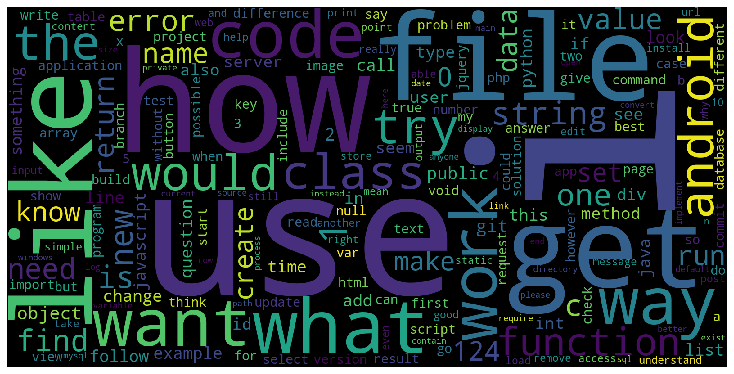

In [60]:
tupl = dict(word_to_count_map.items())
word_cloud = WordCloud(width=1600, height=800,).generate_from_frequencies(tupl)
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Observations:
    1. "I", "use", "file", "like", "get", "what" sont les mots les plus fréquents.

In [61]:
word_df_sorted.head(20)["word"]

32078           i
66963         use
30348         how
25289        file
27582         get
38015        like
69696        what
69398         way
15648        code
69312        want
70295        work
70389       would
63180         the
65228         try
8720      android
15165       class
27148    function
1168            1
60154      string
43612         new
Name: word, dtype: object

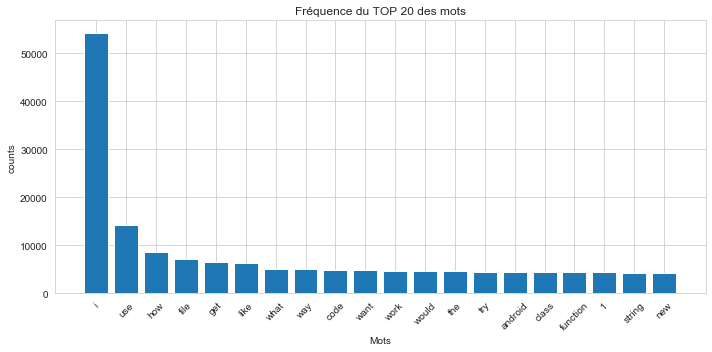

In [62]:
i=np.arange(20)
plt.figure(figsize=(10, 5))
plt.bar(word_df_sorted.head(20)["word"], word_df_sorted.head(20)["counts"])
plt.title("Fréquence du TOP 20 des mots")
plt.xlabel("Mots")
plt.ylabel("counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
df.drop(columns=["words_count"], inplace=True)

In [65]:
df.to_csv("data/clean.csv", index=False)